# Oct 11th, 2022 (Rot Conv verify)

**Motivation**: Play around with rotational conv layer.  Does it do what it's supposed to? <br>

In [1]:
# HIDE CODE


import os
import sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from model.vae import ConfigVAE, VAE
from utils.plotting import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
from utils.process import setup_supervised_data
from analysis.sta import compute_sta
from analysis.hyperflow import *

from torch import nn
from torch.nn import functional as F

## Test Rot Conv

In [3]:
x = torch.randn((13, 2, 16, 16, 24))
x.shape

torch.Size([13, 2, 16, 16, 24])

In [4]:
from model.vae import RotConv3d
conv = RotConv3d(co=6, n_rots=8, kernel_size=3, padding='same')

In [5]:
y = conv(x)
y.shape

torch.Size([13, 48, 16, 16, 24])

In [6]:
w = conv._get_augmented_weight()
w.shape

torch.Size([48, 2, 3, 3, 3])

In [7]:
x = np.arange(31)
xx, yy = np.meshgrid(x, x)
pos = np.concatenate([
    np.expand_dims(xx, -1),
    np.expand_dims(yy, -1),
], axis=-1)

rv = sp_stats.multivariate_normal((19, 11), 10)
rho = rv.pdf(pos)

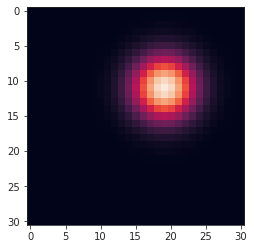

In [8]:
plt.imshow(rho);

In [9]:
theta = np.deg2rad(30)
vx = rho * np.cos(theta)
vy = rho * np.sin(theta)
v = np.concatenate([
    np.expand_dims(vx, -1),
    np.expand_dims(vy, -1),
], axis=-1)
v.shape

(31, 31, 2)

In [10]:
rho, theta = to_polar(v)

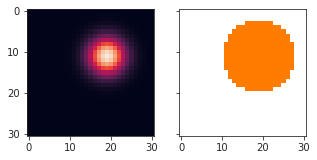

In [11]:
fig, axes = create_figure(1, 2, (5, 3), 'all', 'all')

axes[0].imshow(rho)
x2p = mwh(rho < np.quantile(rho.ravel(), 0.75), theta)
axes[1].imshow(x2p, vmin=0, vmax=2*np.pi, cmap='hsv')

In [12]:
x = torch.randn((1, 2, 64, 64, 1))
x.shape

torch.Size([1, 2, 64, 64, 1])

In [13]:
conv = RotConv3d(co=5, n_rots=8, kernel_size=31, padding='same')
conv.weight.shape

torch.Size([5, 2, 31, 31, 31])

In [14]:
conv._get_augmented_weight().shape

torch.Size([40, 2, 31, 31, 31])

In [15]:
y = conv(x)
y.shape

torch.Size([1, 40, 64, 64, 1])

/home/hadi/Dropbox/git/_MTMST/model/vae.py:124: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484810403/work/aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv3d(


torch.Size([1, 40, 64, 64, 1])

In [16]:
w_test = []
for theta in np.deg2rad([10, 20, 30, 40, 50]):
    vx = rho * np.cos(theta)
    vy = rho * np.sin(theta)
    w_test.append(np.expand_dims(np.concatenate([
        np.expand_dims(vx, 0),
        np.expand_dims(vy, 0),
    ], axis=0), axis=0))
w_test = np.concatenate(w_test)
w_test = torch.tensor(w_test)
w_test.shape

torch.Size([5, 2, 31, 31])

In [17]:
conv.weight.data[..., 0] = w_test
w_aug = conv._get_augmented_weight()
w_aug_reshape = w_aug.view(conv.out_channels, conv.n_rots, *w_aug.shape[1:])

w_aug.shape, w_aug_reshape.shape

(torch.Size([40, 2, 31, 31, 31]), torch.Size([5, 8, 2, 31, 31, 31]))

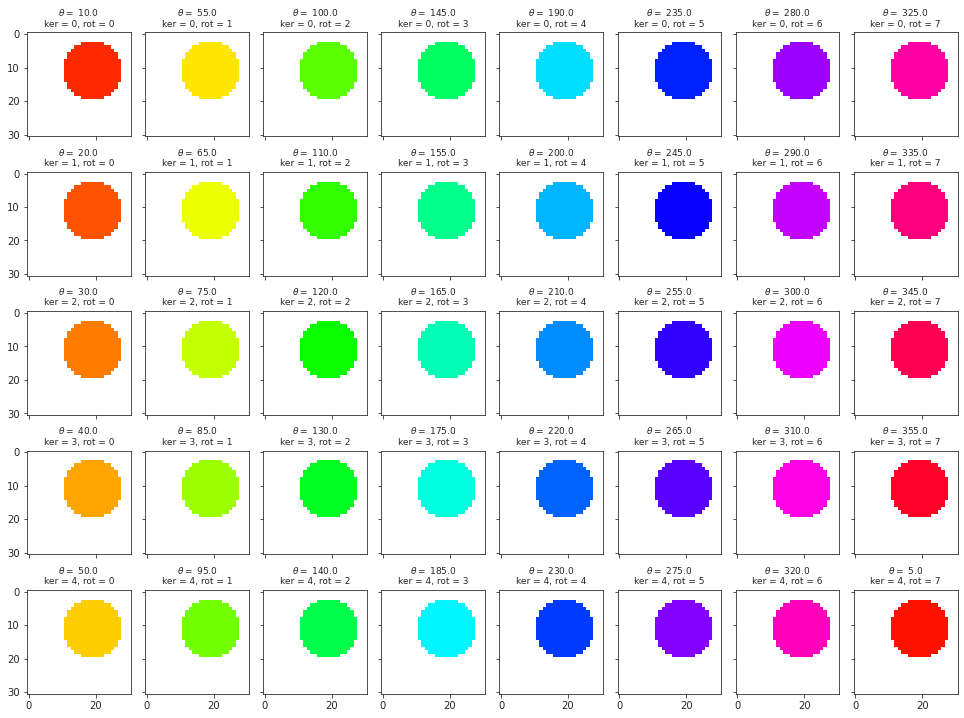

In [18]:
fig, axes = create_figure(conv.out_channels, conv.n_rots, (13.5, 10), 'all', 'all', tight_layout=True)

for i in range(conv.out_channels):
    for j in range(conv.n_rots):
        a = w_aug_reshape.detach().numpy()[i, j]
        rho, theta = to_polar(np.transpose(a[..., 0], (1, 2, 0)))
        x2p = mwh(rho < np.quantile(rho.ravel(), 0.75), theta)
        deg = np.round(np.rad2deg(theta[rho == np.max(rho)].item()), 3)
        axes[i, j].imshow(x2p, vmin=0, vmax=2*np.pi, cmap='hsv')
        axes[i, j].set_title(r"$\theta =$" + f" {deg}" + f"\nker = {i}, rot = {j}", fontsize=9)
plt.show()

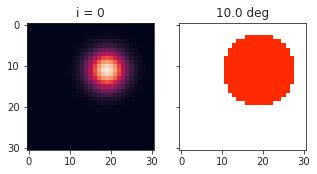

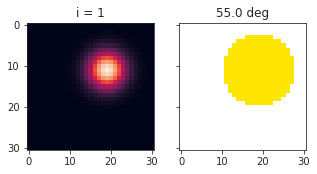

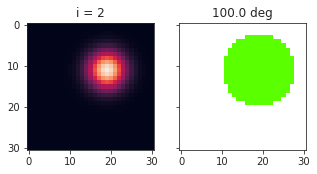

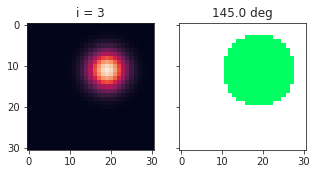

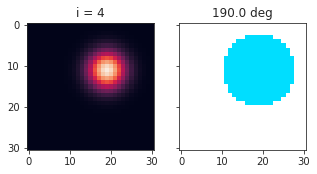

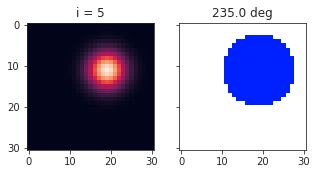

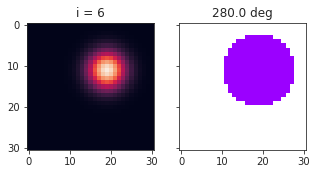

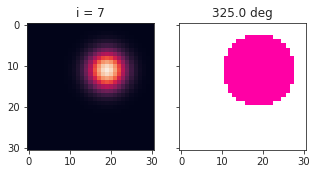

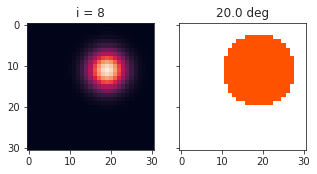

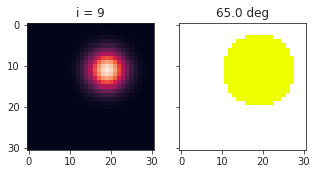

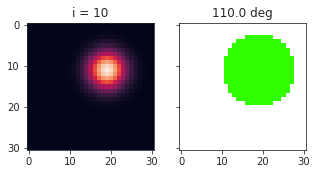

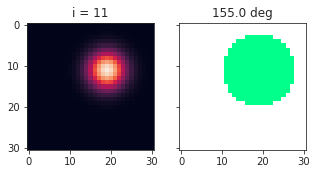

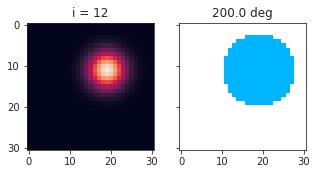

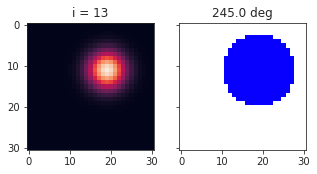

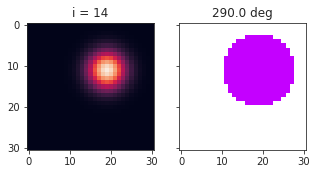

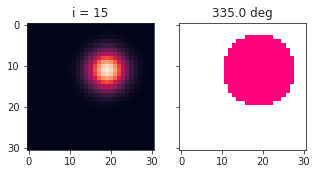

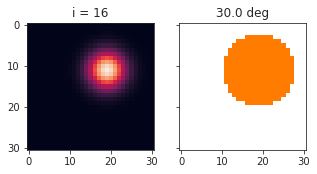

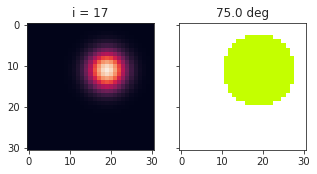

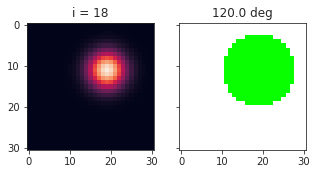

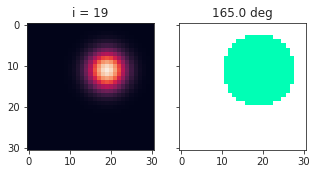

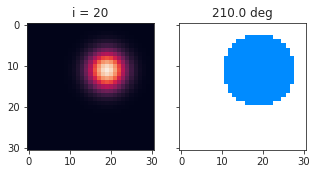

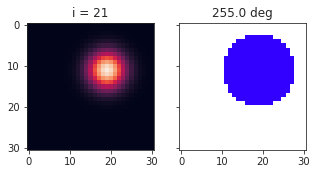

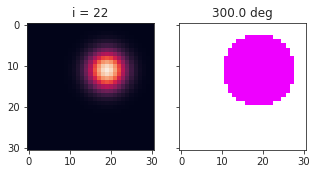

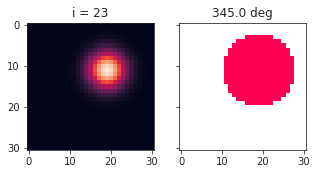

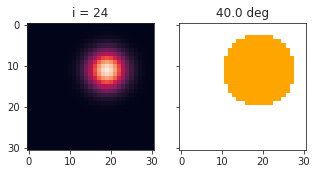

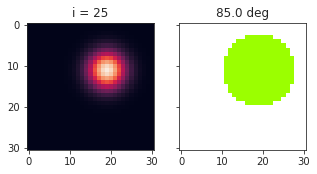

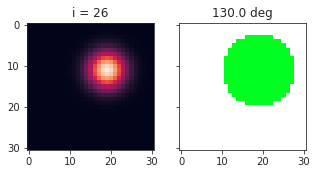

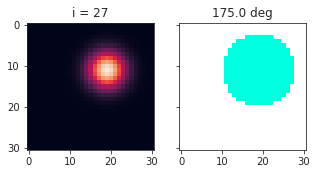

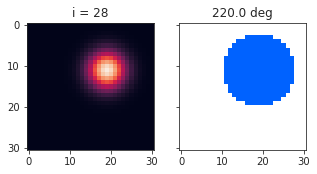

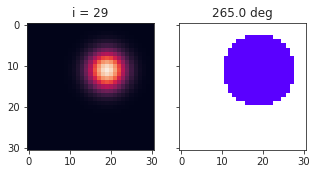

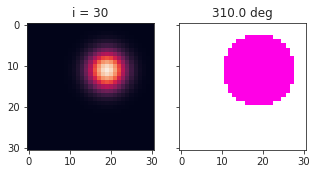

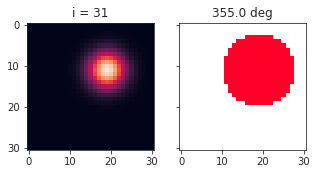

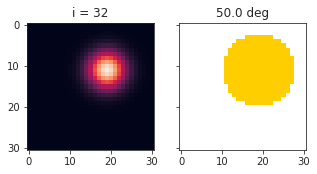

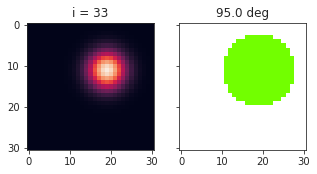

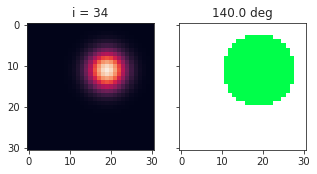

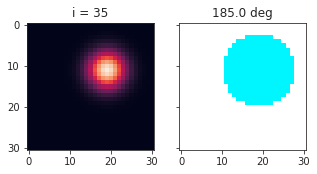

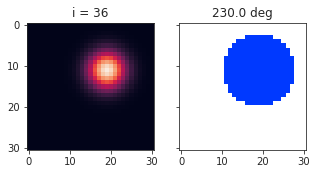

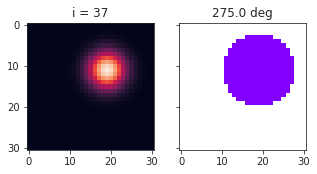

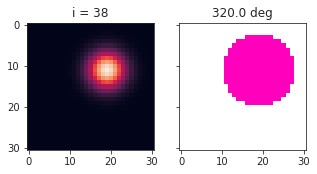

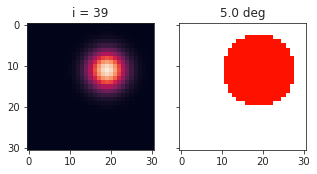

In [19]:
for ii, a in enumerate(w_aug.detach().numpy()):
    rho, theta = to_polar(np.transpose(a[..., 0], (1, 2, 0)))
    
    fig, axes = create_figure(1, 2, (5, 3), 'all', 'all')
    axes[0].imshow(rho)
    axes[0].set_title(f"i = {ii}")
    x2p = mwh(rho < np.quantile(rho.ravel(), 0.75), theta)
    deg = np.round(np.rad2deg(theta[rho == np.max(rho)].item()), 3)
    axes[1].imshow(x2p, vmin=0, vmax=2*np.pi, cmap='hsv')
    axes[1].set_title(f"{deg} deg")
    plt.show()